In [19]:
import csv
import numpy as np

#Read data file
def read_csv_file(filename):
    coordinates = []

    with open(filename, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            x = float(row['X (nm)'])
            y = float(row['Y (nm)'])
            coordinates.append([x, y])
    
    return np.array(coordinates)



filename = "ONI RESULTS_4.csv"
coordinates = read_csv_file(filename)




(1171550, 2)


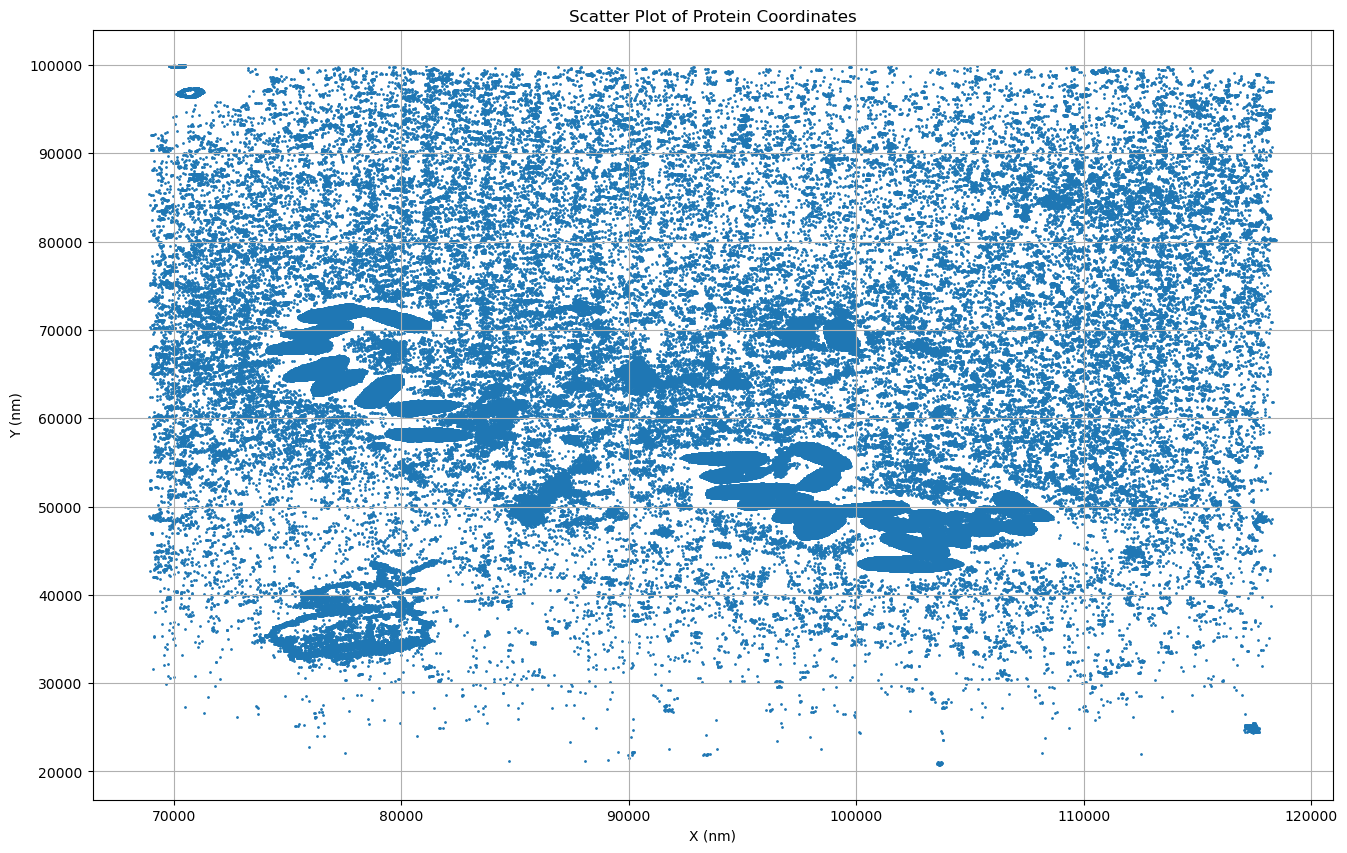

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# coordinates = scaler.fit_transform(coordinates)


print(coordinates.shape)
#A simple function to plot
def plotar(coordinates=coordinates,s=1,alpha=1):
    plt.figure(figsize=(16, 10))
    plt.scatter(coordinates[:, 0], coordinates[:, 1], s=s, alpha=alpha)
    plt.title('Scatter Plot of Protein Coordinates')
    plt.xlabel('X (nm)')
    plt.ylabel('Y (nm)')
    plt.grid(True)
    plt.show()
plotar()

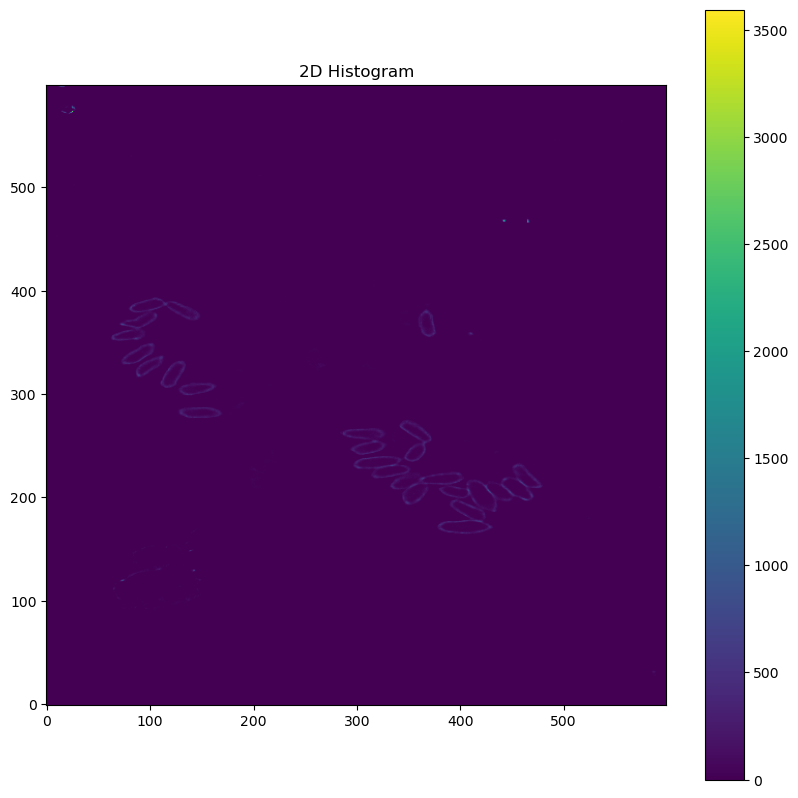

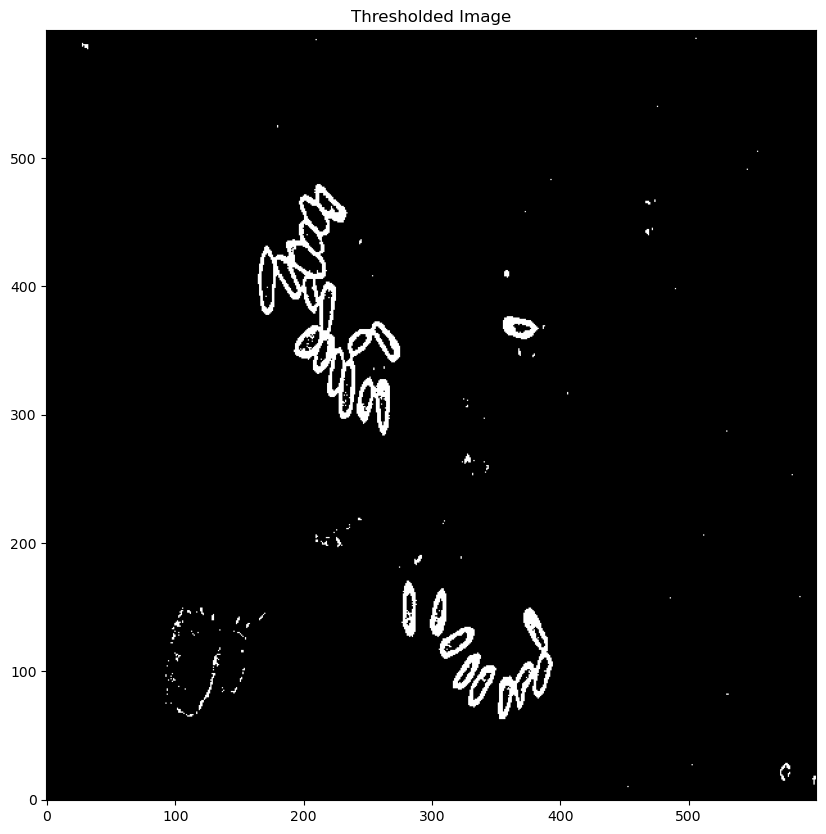

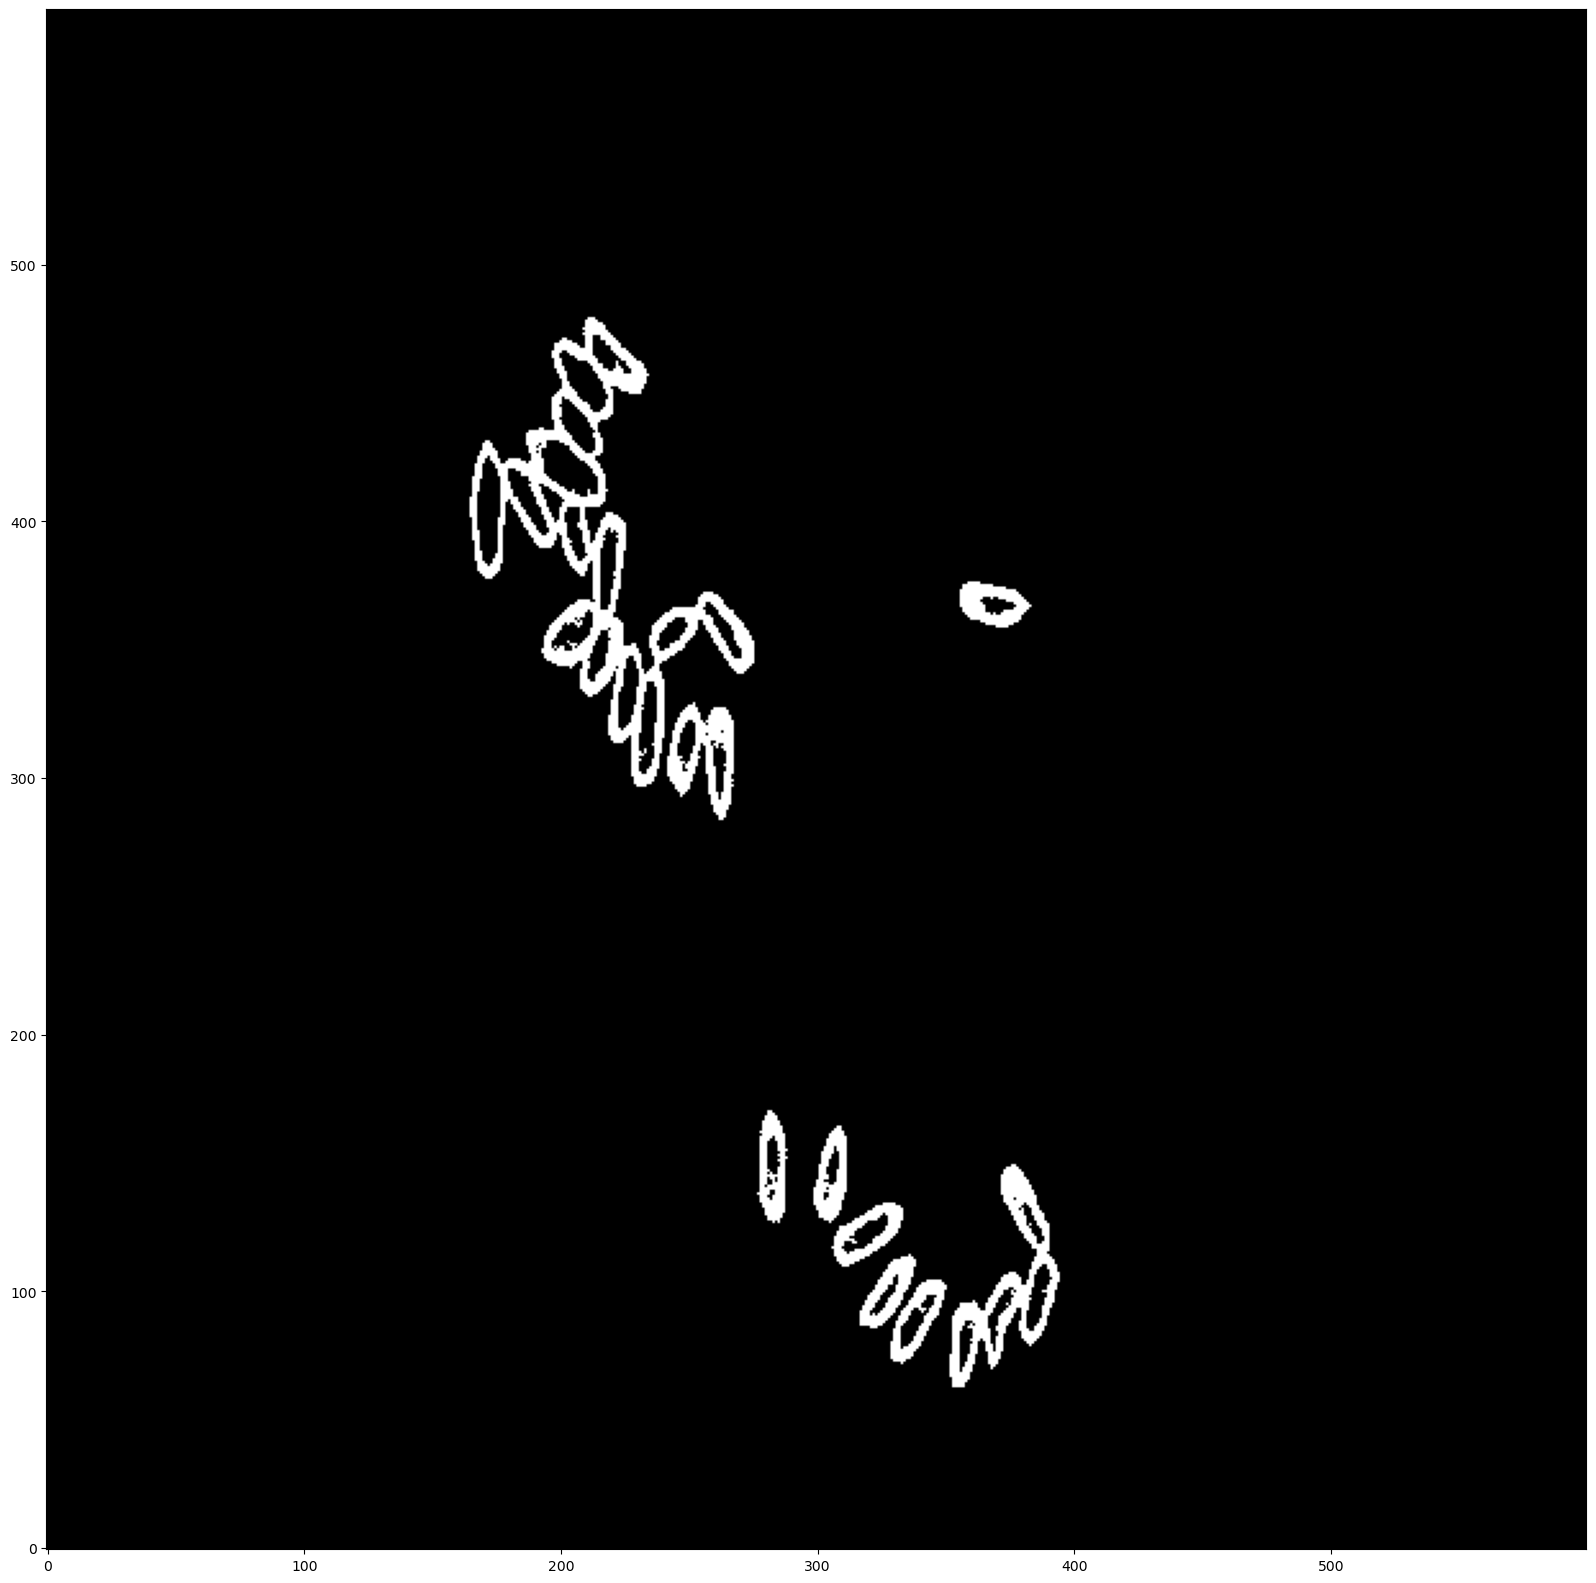

In [21]:
import numpy as np
import cv2
from skimage.morphology import dilation, disk,erosion
import matplotlib.pyplot as plt


# Convert data into a 2D histogram
hist, xedges, yedges = np.histogram2d(coordinates[:,0], coordinates[:,1], bins=(600,600))
bin_width_x=np.max(coordinates[:,0])
bin_width_y=np.max(coordinates[:,1])

plt.figure(figsize=(10,10))
plt.imshow(hist.T, origin='lower')
plt.title('2D Histogram')
plt.colorbar()
plt.show()

# Threshold the histogram to create a binary image
# Adjust the threshold value based on data -> major weakness(manual input)
thresh = np.where(hist > 25, 255, 0).astype(np.uint8)

plt.figure(figsize=(10,10))
plt.imshow(thresh, cmap='gray', origin='lower')
plt.title('Thresholded Image')
plt.show()

#connect neighboring pixels to form regions
num_labels, labels = cv2.connectedComponents(thresh)

# Initialize an empty image
filtered = np.zeros_like(thresh)

# Define the minimum area
min_area = 100  # adjust this based on your data

# Iterate through the unique labels (connected components) and filter the regions by area
for label in range(1, num_labels):
    component = np.where(labels == label, 255, 0).astype('uint8')

    if cv2.countNonZero(component) > min_area:
        filtered = cv2.bitwise_or(filtered, component)

plt.figure(figsize=(20,20))
plt.imshow(filtered, cmap='gray', origin='lower')
plt.show()




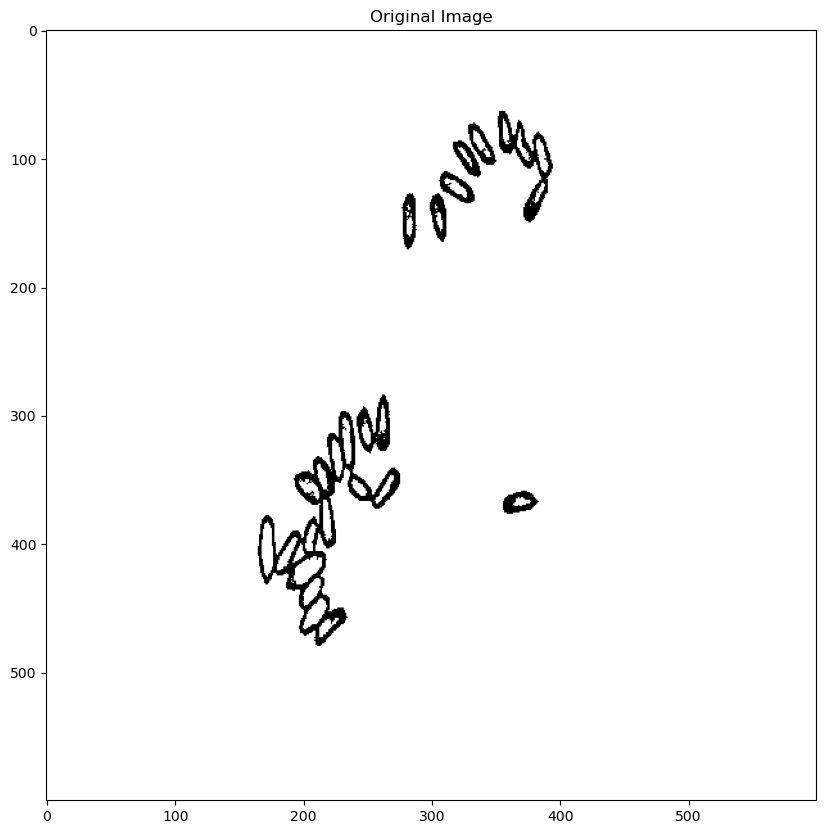

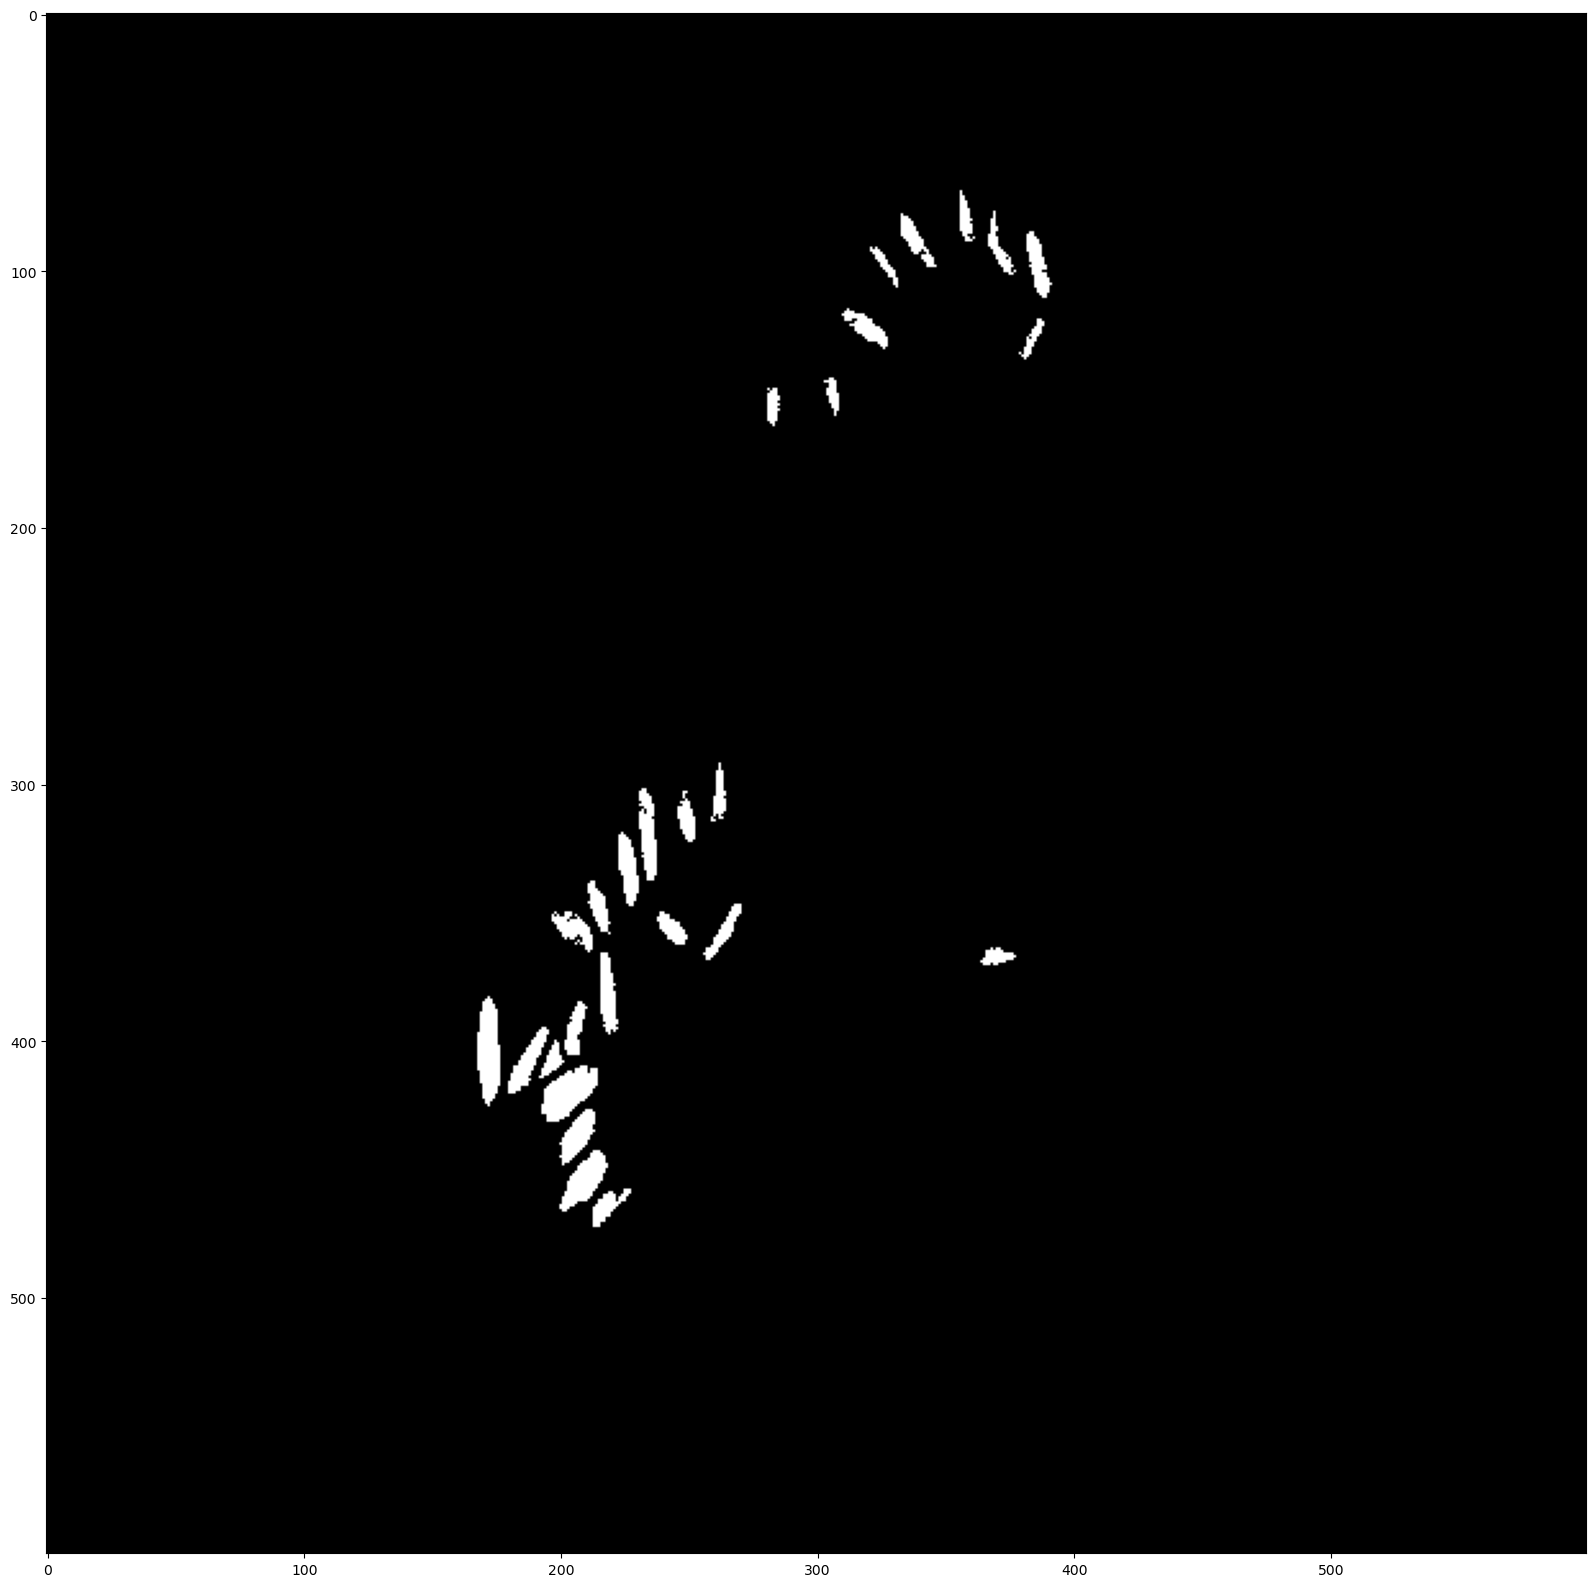

In [22]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops


boundary_img=filtered

# Invert the image to get the cells interiors
inverted_img = cv2.bitwise_not(boundary_img)
plt.figure(figsize=(10, 10))
plt.imshow(inverted_img, cmap='gray')
plt.title('Original Image')
plt.show()

# Label connected components in the image
labels = label(inverted_img)

# Get properties of the labeled regions
regions = regionprops(labels)

# Define minimum and maximum area
min_area = 20 # Minimum area to keep
max_area = 90000  # Maximum area to keep

# Find the label of the largest region (which should be the background)
background_label = np.argmax([region.area for region in regions]) + 1

# Create an image where the background is black and the interiors of the ellipses are white
interior_img = np.where(labels == background_label, 0, 255).astype('uint8')

# Filter out regions that don't meet the area criteria
filtered_img = np.zeros_like(interior_img)
for region in regions:
    if min_area <= region.area <= max_area and region.label != background_label:
        filtered_img[labels == region.label] = 255

# Create a disk-shaped structuring element for the erosion
se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))

# Erode the filtered image to remove a one-pixel-wide boundary
#filtered_img = cv2.erode(filtered_img, se)

# Display the image
plt.figure(figsize=(20,20))
plt.imshow(filtered_img, cmap='gray')
plt.show()



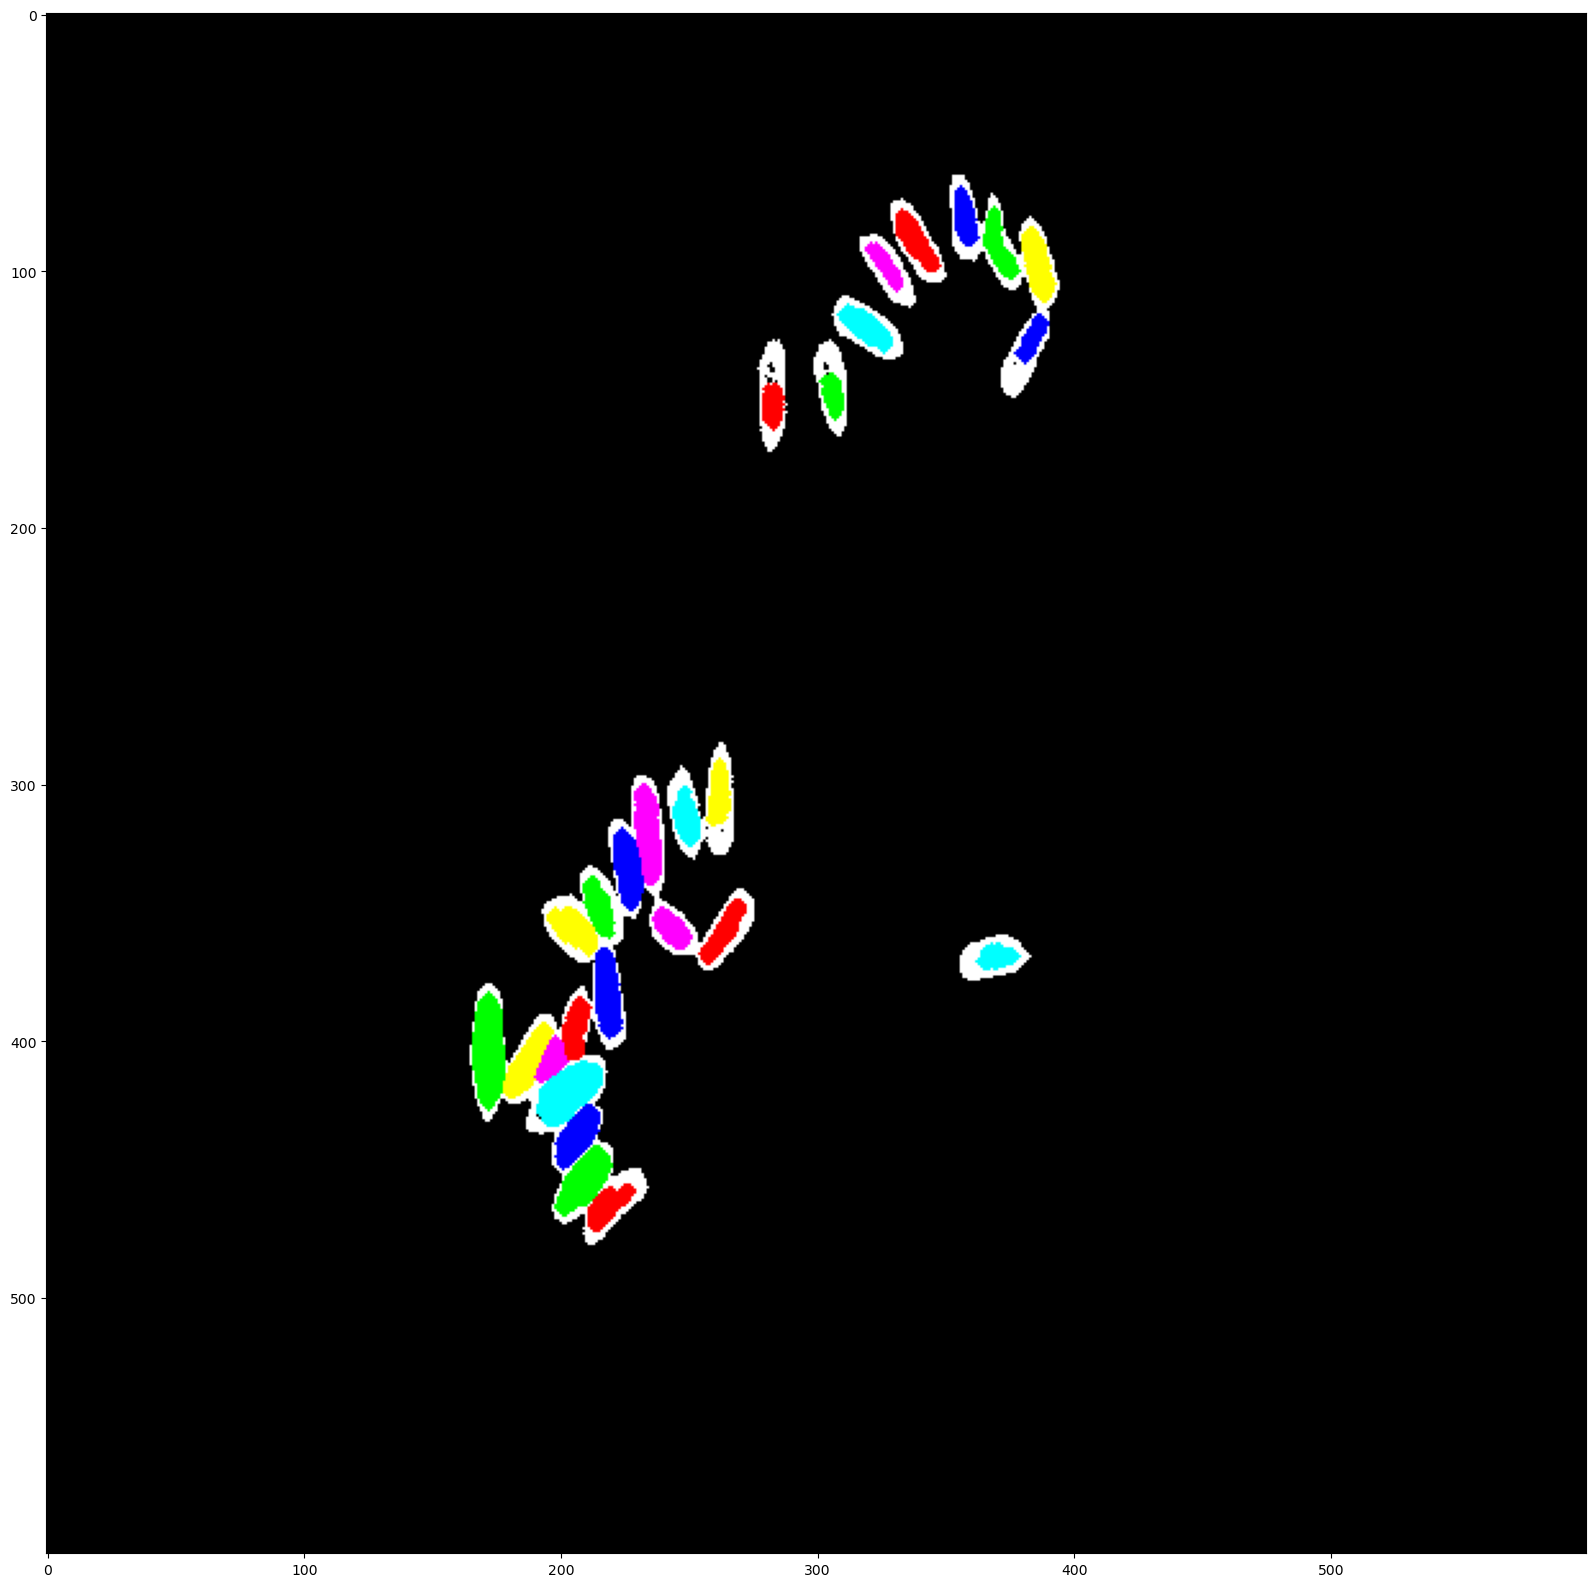

In [23]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.morphology import dilation, disk

# Perform connected component analysis on the filtered image
filtered_labels = label(filtered_img)

# Get properties of the filtered regions
filtered_regions = regionprops(filtered_labels)

# Create a disk-shaped structuring element for the dilation
se = disk(2)

# Prepare the image for visualizing the ellipses (converted to 3 channels)
ellipse_img = cv2.cvtColor(boundary_img.copy(), cv2.COLOR_GRAY2BGR)

# Initialize color index
color_index = 0

# Define some colors for visualization (BGR format)
colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0), (255, 255, 0), (255, 0, 255), (0, 255, 255)]

dilated_region_img=[]
# Iterate over the filtered regions
for region in filtered_regions:
    # Perform ellipse fitting and size filtering
    if region.area >= min_area and region.area <= max_area:
        y0, x0 = region.centroid
        orientation = region.orientation
        x_radius = region.major_axis_length / 2.
        y_radius = region.minor_axis_length / 2.

        # Dilation of the individual region
        region_img = np.zeros_like(filtered_img)
        region_img[filtered_labels == region.label] = 255
        dilated_region_img.append(dilation(region_img, se))
        #dilated_region_img = dilation(region_img, se)


        # Draw the dilated region on the ellipse image
        ellipse_img[dilated_region_img[-1] > 0] = colors[color_index % len(colors)]

        # Draw the ellipse on the image
        ellipse = ((x0, y0), (x_radius, y_radius), np.degrees(orientation))

        # Increment color index
        color_index += 1

# Display the image
plt.figure(figsize=(20,20))

plt.imshow(ellipse_img)
plt.show()



In [24]:
#Expand the interior pixels untill itreaches the cell's boundary or meets another cell

def expand_cells_till_boundary(ellipse_interior_images, boundary_image):
    se = disk(1)

    expanded_ellipse_interior_images = [np.copy(img) for img in ellipse_interior_images]

    for step in range(15):  # Increase this if necessary
        print(f"Dilation step: {step}")  # Debug print
        any_cell_updated = False  

        for i, img in enumerate(expanded_ellipse_interior_images):
            dilated_img = dilation(img, se)
            new_coords = set(zip(*np.where(dilated_img == 255 )))
            old_coords = set(zip(*np.where(img ==255)))
            new_boundary_coords = set(zip(*np.where(np.logical_and(dilated_img ==255, boundary_image <10))))
            
            print(f"Cell {i}: new boundary coords = {len(new_boundary_coords)}, new coords = {len(new_coords)}")

            if len(new_boundary_coords) > 0:
                any_cell_updated = True  # A cell was updated
                new_coords = new_boundary_coords.union(old_coords)
                 # Only add new coords that are on the boundary and do not belong to other cells
                for j, img_j in enumerate(expanded_ellipse_interior_images):
                    if i != j:
                        other_cell_coords = set(zip(*np.where(img_j > 0)))
                        new_coords = new_coords - other_cell_coords
                
                
                coords = np.array(list(new_coords)).T
                expanded_ellipse_interior_images[i][:] = 0
                expanded_ellipse_interior_images[i][coords[0], coords[1]] = 255

        if not any_cell_updated:
            print("No cells were expanded in this step. Exiting...")  # Debug print
            break

    return expanded_ellipse_interior_images




expanded_ellipse_image_final=expand_cells_till_boundary(dilated_region_img,cv2.bitwise_not(filtered))


Dilation step: 0
Cell 0: new boundary coords = 146, new coords = 214
Cell 1: new boundary coords = 175, new coords = 260
Cell 2: new boundary coords = 163, new coords = 269
Cell 3: new boundary coords = 174, new coords = 313
Cell 4: new boundary coords = 121, new coords = 171
Cell 5: new boundary coords = 149, new coords = 264
Cell 6: new boundary coords = 118, new coords = 170
Cell 7: new boundary coords = 114, new coords = 163
Cell 8: new boundary coords = 110, new coords = 174
Cell 9: new boundary coords = 168, new coords = 243
Cell 10: new boundary coords = 244, new coords = 423
Cell 11: new boundary coords = 144, new coords = 232
Cell 12: new boundary coords = 187, new coords = 348
Cell 13: new boundary coords = 153, new coords = 250
Cell 14: new boundary coords = 161, new coords = 259
Cell 15: new boundary coords = 162, new coords = 287
Cell 16: new boundary coords = 118, new coords = 203
Cell 17: new boundary coords = 108, new coords = 168
Cell 18: new boundary coords = 215, new

(311, 2)
(341, 2)
(381, 2)
(363, 2)
(326, 2)
(406, 2)
(336, 2)
(343, 2)
(344, 2)
(391, 2)
(459, 2)
(352, 2)
(382, 2)
(351, 2)
(398, 2)
(380, 2)
(278, 2)
(355, 2)
(420, 2)
(581, 2)
(268, 2)
(377, 2)
(146, 2)
(570, 2)
(328, 2)
(445, 2)
(380, 2)


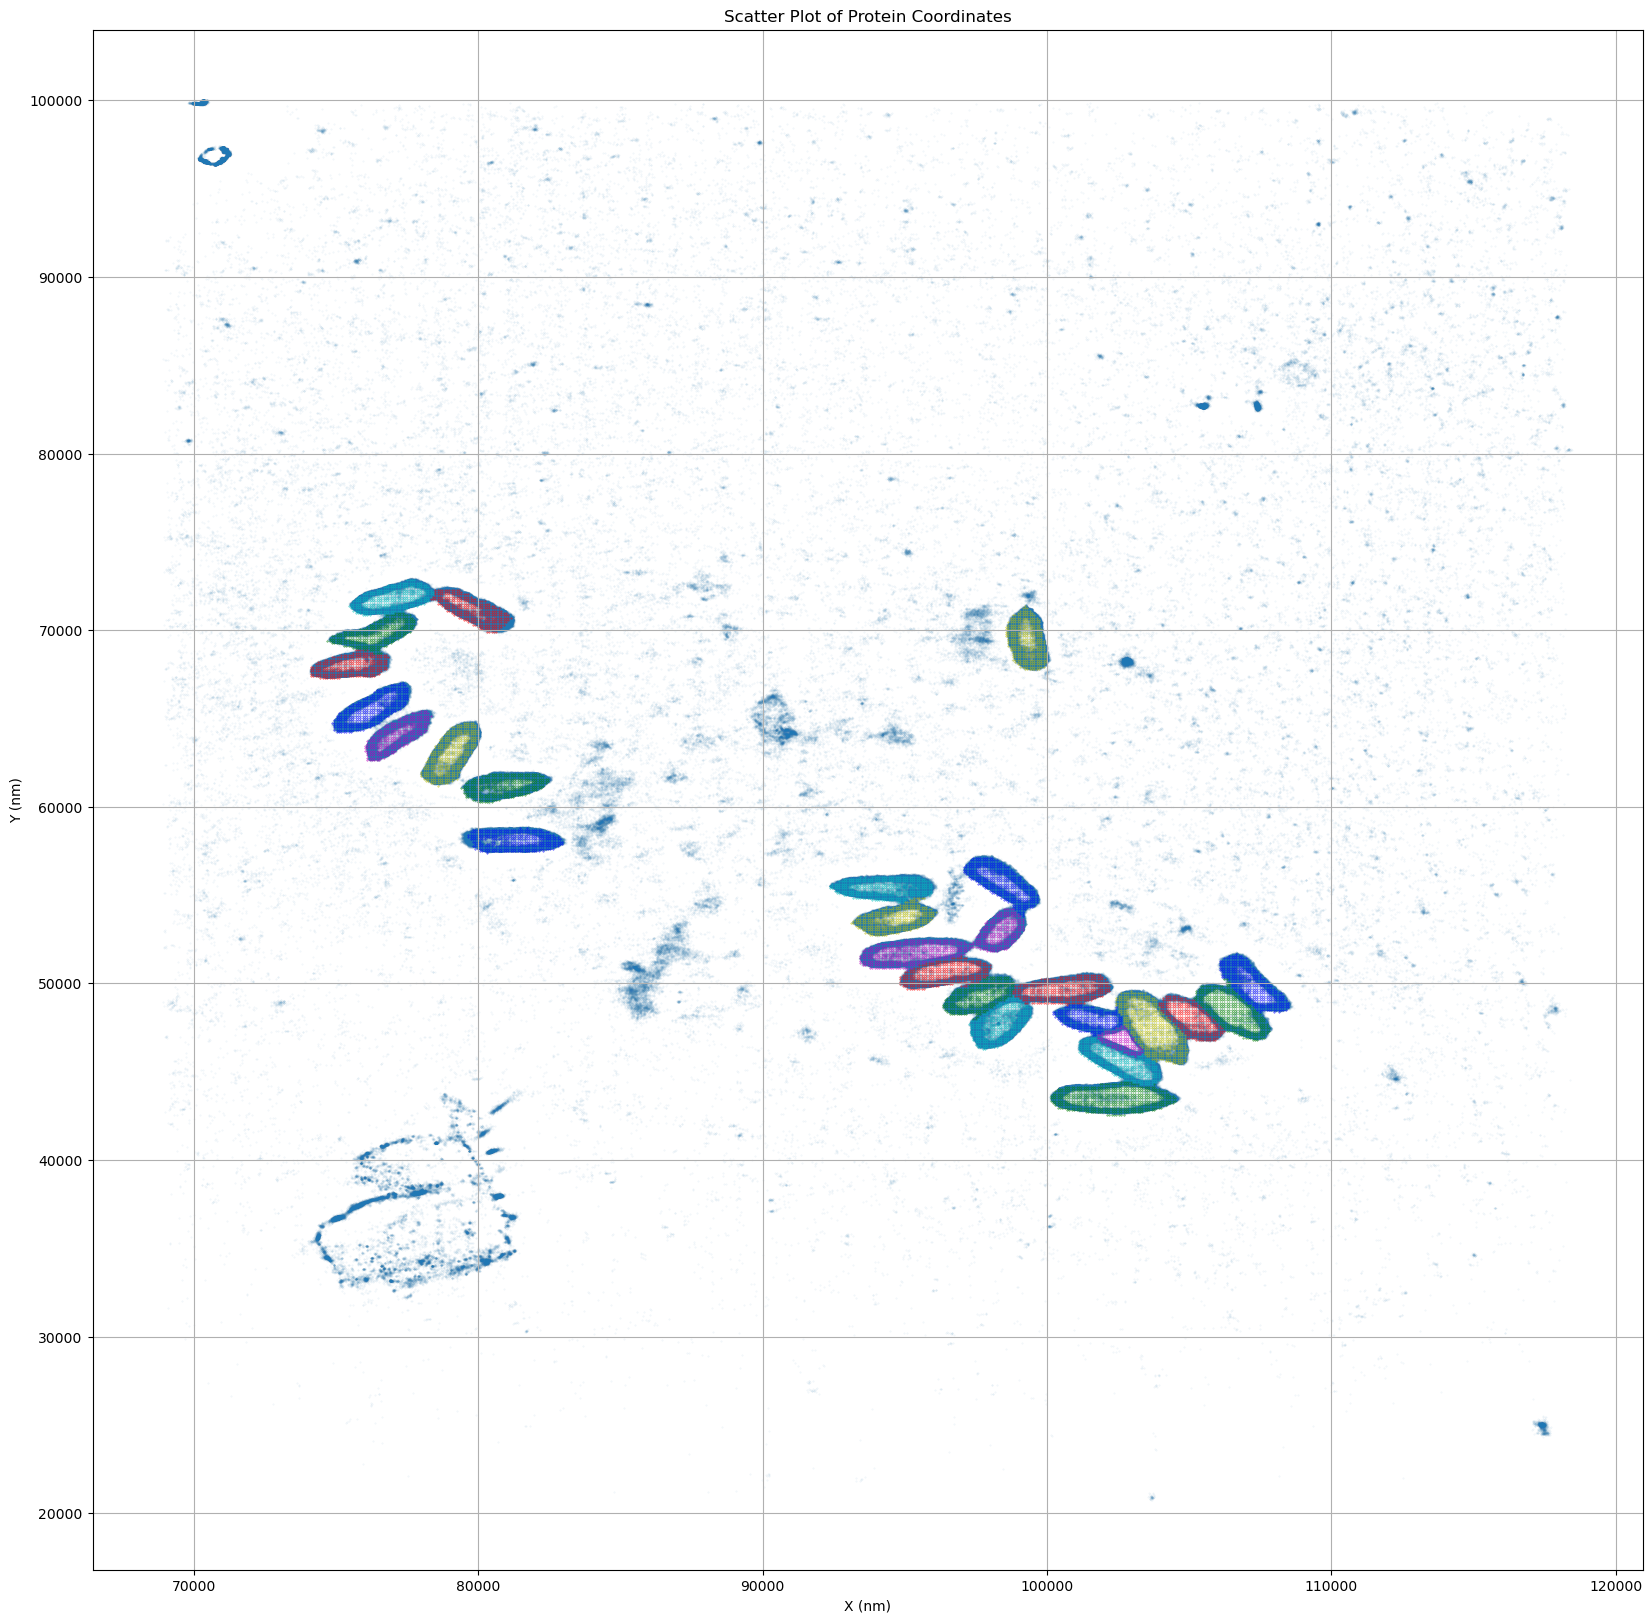

27


In [25]:
def Image_To_Coordinates(Region,xedges=xedges,yedges=yedges):
    # Find the pixel indices where the filtered image is white
    indices = np.where(Region == 255)

    # Map the pixel indices back to the original coordinates
    x_coords = xedges[indices[0]]
    y_coords = yedges[indices[1]]

    # Stack the x and y coordinates
    coordinates = np.vstack((x_coords, y_coords)).T
    coordinates = np.vstack((x_coords, y_coords)).T


    #plotar(coordinates,alpha=1)
    print(coordinates.shape)

    return coordinates

cell_grided_coordinates=[]
for i,region in enumerate(expanded_ellipse_image_final):
    cell_grided_coordinates.append(Image_To_Coordinates(expanded_ellipse_image_final[i]))


import matplotlib.pyplot as plt

def plot_coordinates_on_image(Raw_data, cell_coordinates):
    """
    Plots cell coordinates on top of an image, with each set of coordinates in a different color.
    Args:
    image: numpy array of shape (height, width) representing the original image
    cell_coordinates: list of numpy arrays, where each array is of shape (n, 2) and contains the (x, y) coordinates of a cell
    """
    # Plot the original image
    plt.figure(figsize=(20, 20))
    plt.scatter(Raw_data[:, 0], Raw_data[:, 1], s=0.1, alpha=0.1)
    plt.title('Scatter Plot of Protein Coordinates')
    plt.xlabel('X (nm)')
    plt.ylabel('Y (nm)')
    plt.grid(True)
    #plt.show()
    
    # Define some colors for the plot
    colors = ['r', 'g', 'b', 'c', 'm', 'y']
    
    # Plot each set of cell coordinates in a different color
    for i, coordinates in enumerate(cell_coordinates):
        plt.scatter(coordinates[:, 0], coordinates[:, 1], c=colors[i % len(colors)], s=0.1)

    plt.show()

# Call the function with your data
plot_coordinates_on_image(coordinates, cell_grided_coordinates)
print(len(cell_grided_coordinates))


In [ ]:
from scipy.spatial import cKDTree

#Known the grid of a cell, this function finds the points that are in that cell
def find_nearby_points_chunked(dataset1, dataset2, radius, chunk_size=5000):
    """
    Find the points in dataset1 that are within a certain distance to at least
    one point in dataset2.
    
    Args:
    dataset1 (numpy.array): A 2D array where each row represents a point.
    dataset2 (numpy.array): A 2D array where each row represents a point.
    radius (float): The distance threshold.
    chunk_size (int): The number of points from dataset1 to process at a time.
    
    Returns:
    nearby_points (numpy.array): A 2D array where each row represents a point in dataset1 that is within the specified distance to at least one point in dataset2.
    """
    # Build a k-d tree for dataset2
    tree = cKDTree(dataset2)

    nearby_points = []

    # Split dataset1 into chunks to avoid using too much memory
    chunks = [dataset1[i:i+chunk_size] for i in range(0, len(dataset1), chunk_size)]

    for chunk in chunks:
        # Find the points in the chunk that are within the specified distance to at least one point in dataset2
        indices = tree.query_ball_point(chunk, r=radius)

        # Convert the list of indices to a Boolean mask
        mask = [bool(idx) for idx in indices]

        # Use the mask to select the nearby points
        nearby_points.extend(chunk[mask])
        #print("a")

    return np.array(nearby_points)


#coordinates_scaled=preprocess_coords(coordinates)
#contour_coordinates_scaled=preprocess_coords(contour_coordinates)
cell_real_coordinates=[]


#plt.show()

# Define some colors for the plot
colors = ['r', 'g', 'b', 'c', 'm', 'y']
cell_count=[]

# Plot each set of cell coordinates in a different color
for i, coordinate in enumerate(cell_grided_coordinates):
    cell_real_coordinates.append( np.array (find_nearby_points_chunked(coordinates,coordinate,100)) )
    cell_count.append(cell_real_coordinates[-1].shape[0])

    print(cell_real_coordinates[i].shape)
    plt.figure(figsize=(20, 20))
    plt.title("Count " + str(cell_real_coordinates[-1].shape[0]), fontsize=20)
    plt.xlabel('X (nm)')
    plt.ylabel('Y (nm)')
    plt.grid(True)
    plt.scatter(coordinates[:, 0], coordinates[:, 1], s=0.1, alpha=0.1)

    plt.scatter(cell_real_coordinates[-1][:, 0], cell_real_coordinates[-1][:, 1], c=colors[i % len(colors)], s=0.1)
    plt.savefig("Cell " + str(i))

print("Media, " + str(((sum(cell_count))+29125)/(len(cell_count)+1)))
 